**
## 导入必要的库
我们需要导入一个叫 captcha 的库来生成验证码。
我们生成验证码的字符由数字和大写字母组成。

In [3]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 170, 80, 4, len(characters)

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


# 定义数据生成器

In [4]:
from keras.utils.np_utils import to_categorical

def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

Using TensorFlow backend.


# 测试生成器

Text(0.5,1,u'G0FA')

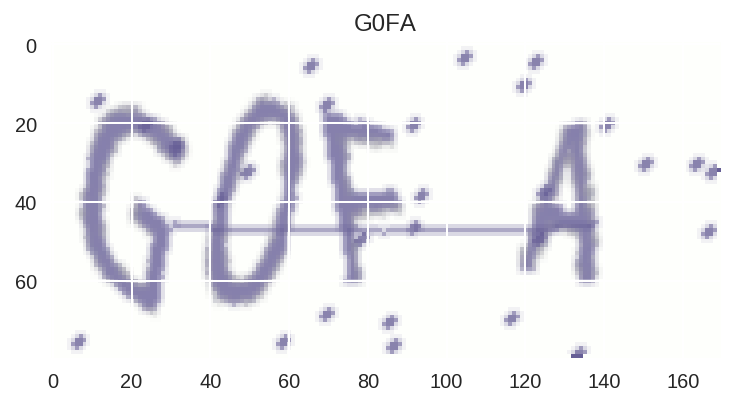

In [5]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])

X, y = next(gen(1))
plt.imshow(X[0])
plt.title(decode(y))

# 定义网络结构

In [0]:
from keras.models import *
from keras.layers import *


input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(4):
    x = Conv2D(32*2**i, (3, 3), activation='relu')(x)
    x = Conv2D(32*2**i, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
model = Model(inputs=input_tensor, outputs=x)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

# 网络可视化

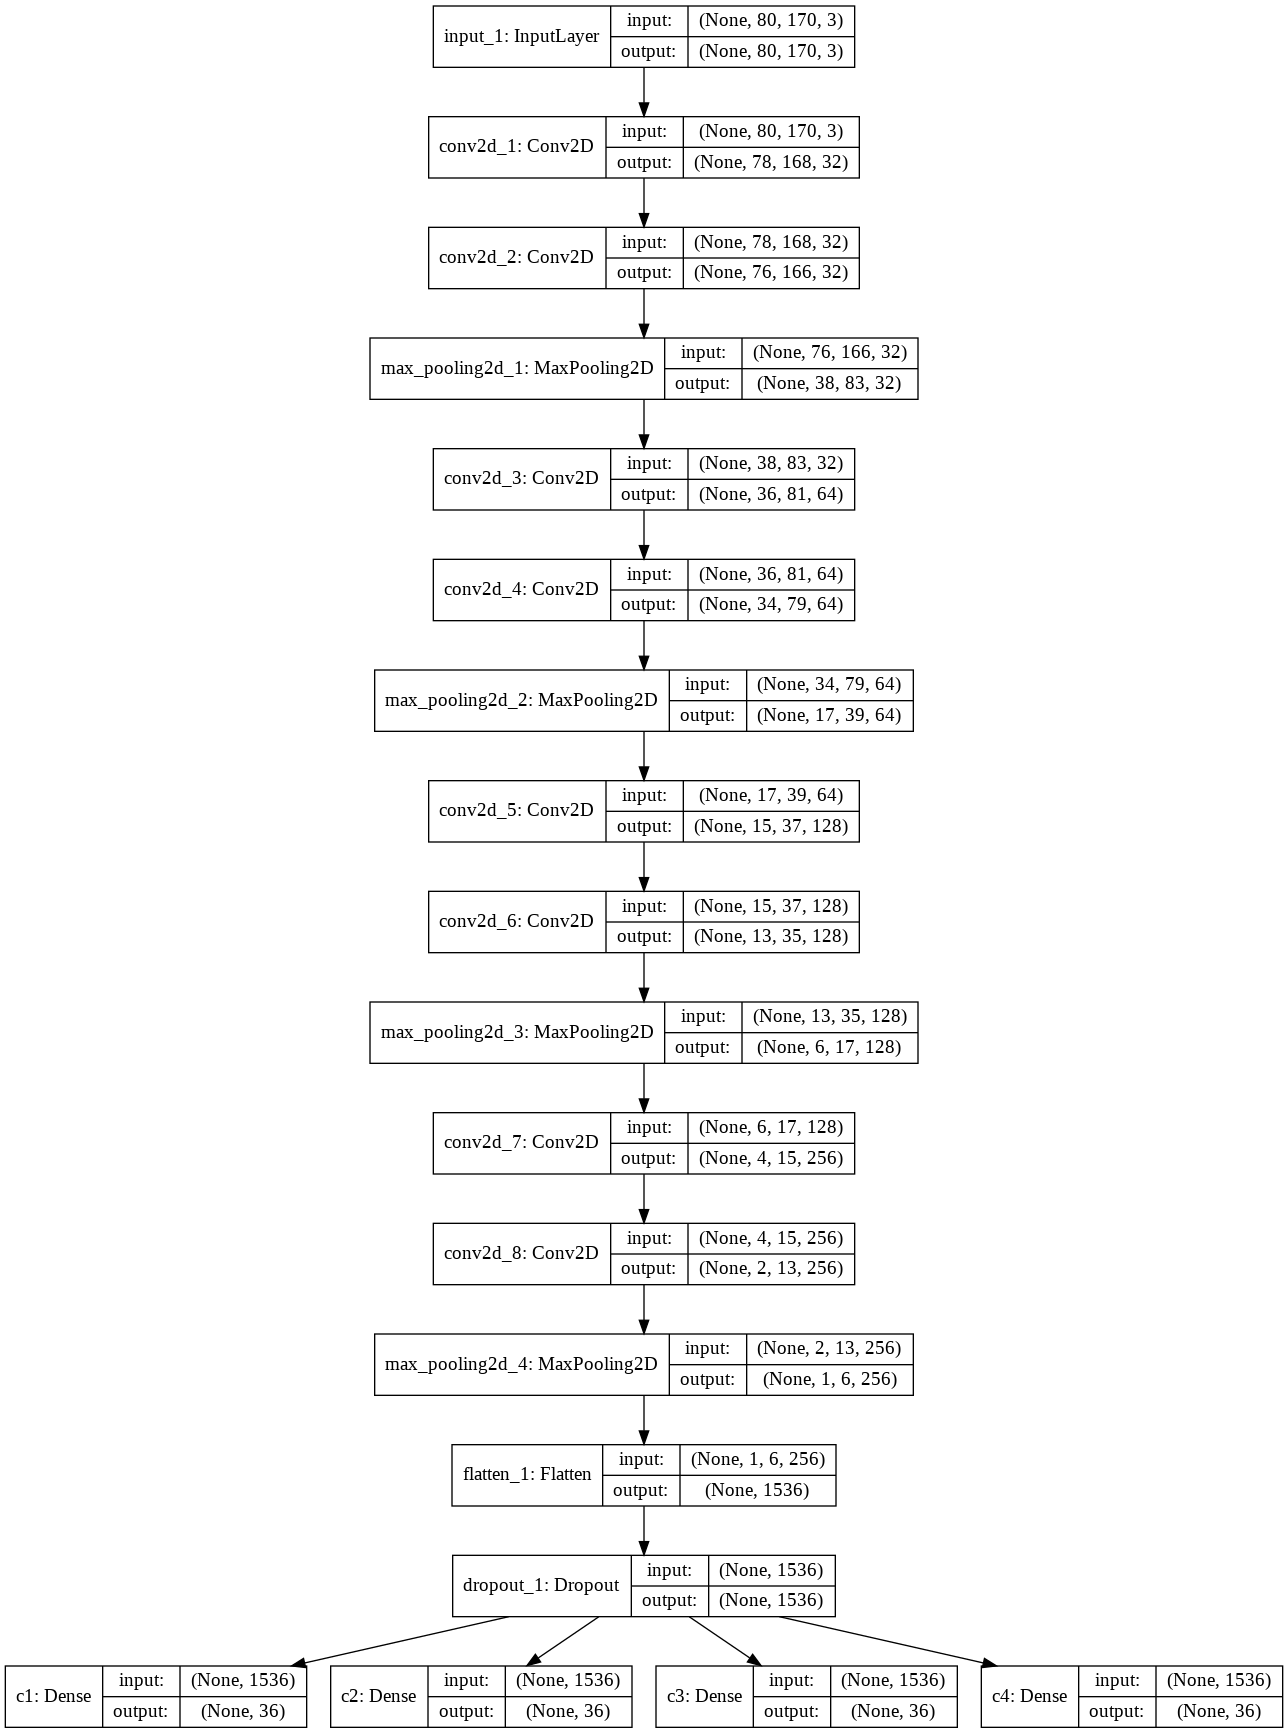

In [7]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file="model.png", show_shapes=True)
Image('model.png')

# 训练模型

In [0]:
model.fit_generator(gen(), steps_per_epoch=51200, epochs=5, 
                    validation_data=gen(), validation_steps=1280,)